# Import & Paths

In [ ]:
from google.colab import userdata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
import cv2

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return

In [ ]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')
metadata_path = os.path.join(dataset_path, 'dataset_metadata.json')


# Check if we can pre-load all images

You can check the available memory in your Colab runtime using the `%shell` magic command and system commands.

In [ ]:
%shell free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       699Mi       9.0Gi       1.0Mi       2.9Gi        11Gi
Swap:             0B          0B          0B


In [ ]:
# CPUs
%shell nproc

2


In [ ]:
image_dirs = ['clean', 'new', 'ref']
total_size_bytes = 0

for image_dir in image_dirs:
    dir_path = os.path.join(dataset_path, image_dir)
    if os.path.exists(dir_path):
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'): # Assuming your images are PNG files
                file_path = os.path.join(dir_path, filename)
                total_size_bytes += os.path.getsize(file_path)

# Convert bytes to a more readable format (e.g., MB, GB)
total_size_mb = total_size_bytes / (1024 ** 2)
total_size_gb = total_size_bytes / (1024 ** 3)

print(f"Total size of image files: {total_size_bytes} bytes")
print(f"Total size of image files: {total_size_mb:.2f} MB")
print(f"Total size of image files: {total_size_gb:.2f} GB")

Total size of image files: 4190313 bytes
Total size of image files: 4.00 MB
Total size of image files: 0.00 GB


## Pre-load all images

In [ ]:
%%skip Skipping Parallel loading of the images

from joblib import Parallel, delayed
import time

def load_image(file_path, file_id):
    """Loads a single image and returns its ID and data."""
    img = cv2.imread(file_path)
    if img is not None:
        return file_id, img
    return None, None

# --- Example of parallelized loading ---
print("Parallel loading images...")
start_time = time.time()

image_dirs = ['clean', 'new', 'ref']
all_image_files = []

# Collect all image file paths and IDs
for image_dir in image_dirs:
    dir_path = os.path.join(dataset_path, image_dir)
    if os.path.exists(dir_path):
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'):
                file_id = os.path.splitext(filename)[0]
                file_path = os.path.join(dir_path, filename)
                all_image_files.append((file_path, file_id))

# Parallelize the image loading
# n_jobs=-1 uses all available CPU cores
loaded_images_list = Parallel(n_jobs=-1)(
    delayed(load_image)(file_path, file_id) for file_path, file_id in all_image_files
    )

# Convert the list of tuples into a dictionary
parallel_loaded_images = {file_id: img for file_id, img in loaded_images_list if file_id is not None}

end_time = time.time()
print(f"Finished parallel loading {len(parallel_loaded_images)} images in {end_time - start_time:.2f} seconds.")

# You can now use the 'parallel_loaded_images' dictionary
# For example, to access an image:
# if '4547604' in parallel_loaded_images:
#     display(parallel_loaded_images['4547604'])

Skipping Parallel loading of the images


In [ ]:
# %%skip Comment out skip to load all the images

# Pre-load images into dictionaries
print("Pre-loading images...")
image_dirs = [os.path.join(dataset_path, image_dir) for image_dir in ['clean', 'new', 'ref']]
images = dict()

for dir_path in image_dirs:
    if os.path.exists(dir_path):
        print(dir_path)
        for i, filename in enumerate(os.listdir(dir_path), start=1):
            print(f"\r{} images: {i} / {len(os.listdir(dir_path))}", end='')
            file_id = os.path.splitext(filename)[0]
            file_path = os.path.join(dir_path, filename)
            img = cv2.imread(file_path)
            if img is not None:
                images[file_id] = img

        print() # After sameline print in loop

print(f"Finished pre-loading {len(images)} images.")

Pre-loading images...
1849 / 1849
1849 / 1849
1849 / 1849
Finished pre-loading 5547 images.


# Visualizations: PSNR vs Pair Score

## Calculate PSNR per Image Pair

In [ ]:
%%skip Comment out skip to calculate and save PSNR table

def calculate_psnr(img1, img2):
    """Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images."""
    # Ensure images are of the same size and type
    # Convert images to float32 for accurate calculations
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Create a list of dictionaries to store the data for the table
psnr_table_data = []

# Iterate through metadata to get image pairs and calculate PSNR
# Assuming 'images' dictionary is already populated with loaded images
meta = pd.read_json(metadata_path)

print("Generating PSNR table...")
for index, row in meta.iterrows():
    clean_id = str(row['clean_image'])
    distorted_id = str(row['distorted_image'])
    method = row['metadata']['method']

    img_clean = images.get(clean_id)
    img_distorted = images.get(distorted_id)

    if img_clean is not None and img_distorted is not None:
        psnr_val = calculate_psnr(img_clean, img_distorted)
        psnr_table_data.append({
            'clean_image': clean_id,
            'distorted_image': distorted_id,
            'method': method,
            'psnr': psnr_val
        })

print("Finished generating PSNR table.")

# Convert the list of dictionaries into a pandas DataFrame
psnr_table_df = pd.DataFrame(psnr_table_data)

# Define the path to save the PSNR table CSV
psnr_table_path = os.path.join(dataset_path, 'psnr_table.csv')

# Save the DataFrame to a CSV file
psnr_table_df.to_csv(psnr_table_path, index=False)

print(f"PSNR table saved to {psnr_table_path}")


# Display the DataFrame
display(psnr_table_df)

Generating PSNR table...
Finished generating PSNR table.
PSNR table saved to /content/drive/MyDrive/Colab Notebooks/Samsung/dataset/psnr_table.csv


,clean_image,distorted_image,method,psnr
0,4547604,4547601,new,28.426134
1,4547604,4547602,ref,35.604702
2,4547612,4547609,new,33.684372
3,4547612,4547610,ref,38.338356
4,4547644,4547641,new,32.582279
...,...,...,...,...
3693,4656722,4656720,ref,36.325245
3694,4656766,4656763,new,38.017212
3695,4656766,4656764,ref,39.463993
3696,4656822,4656819,new,34.693600


from matplotlib import pyplot as plt
psnr_table_df['psnr'].plot(kind='hist', bins=20, title='psnr')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
psnr_table_df.groupby('method').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
psnr_table_df['psnr'].plot(kind='line', figsize=(8, 4), title='psnr')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(psnr_table_df['method'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(psnr_table_df, x='psnr', y='method', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## PSNR Histogram

Calculating PSNR...
Finished calculating PSNR.


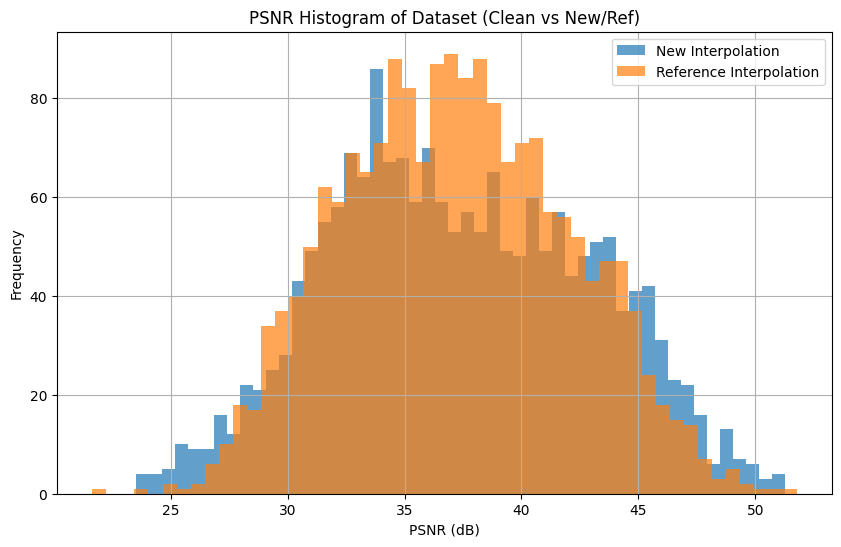

In [ ]:

# List to store PSNR values
psnr_values_new = []
psnr_values_ref = []

# Iterate through metadata to find image pairs and calculate PSNR using pre-loaded images
with open(psnr_table_path) as f:
    psnr_df = pd.read_csv(f)

print("Extracting  PSNR...")
for index, row in psnr_df.iterrows():
    method = row['method']
    psnr_val = row['psnr']

    match method:
        case 'new': psnr_values_new.append(psnr_val)
        case 'ref': psnr_values_ref.append(psnr_val)

print("Finished Extracting PSNR.")

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist(psnr_values_new, bins=50, alpha=0.7, label='New Interpolation')
plt.hist(psnr_values_ref, bins=50, alpha=0.7, label='Reference Interpolation')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.title('PSNR Histogram of Dataset (Clean vs New/Ref)')
plt.legend()
plt.grid(True)
plt.show()

## Violin Plot

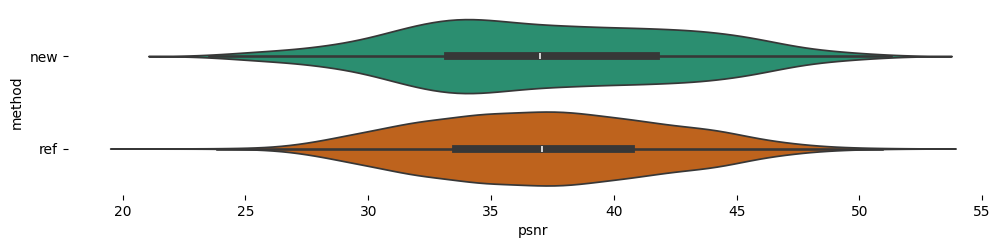

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(psnr_table_df['method'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(psnr_table_df, x='psnr', y='method', inner='box', palette='Dark2', hue='method')
sns.despine(top=True, right=True, bottom=True, left=True)

## Scatter Plot

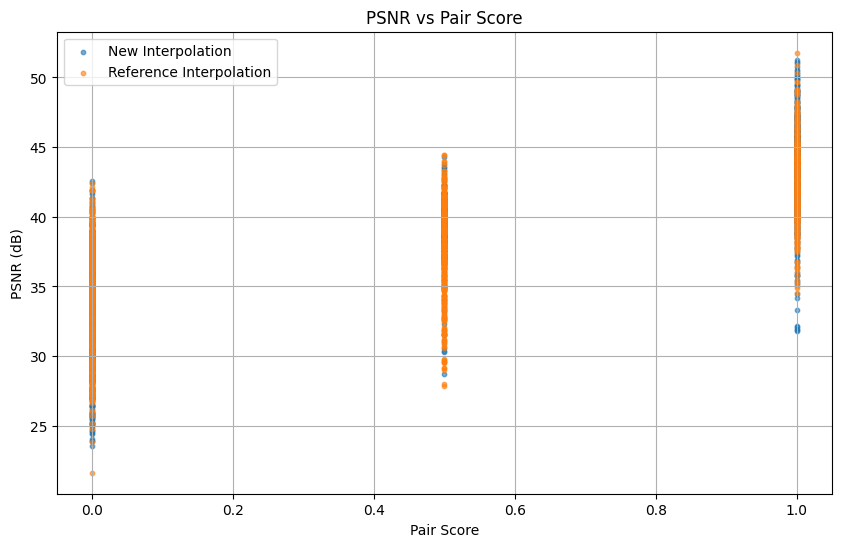

In [ ]:
# Combine PSNR values with pair scores
# Assuming meta DataFrame contains the 'score' column and 'clean_image', 'distorted_image' to match with PSNR calculations

# Load the PSNR table from the saved CSV file
psnr_table_path = os.path.join(dataset_path, 'psnr_table.csv')
psnr_table_df = pd.read_csv(psnr_table_path)

# Merge the PSNR table with the metadata to get scores
# We need to merge based on 'clean_image' and 'distorted_image'
merged_df = pd.merge(psnr_table_df, meta, left_on=['clean_image', 'distorted_image'], right_on=['clean_image', 'distorted_image'])

# Create a DataFrame for scatter plot data
# Select relevant columns and rename for clarity
scatter_df = merged_df[['psnr', 'score', 'method']]

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Separate data by method for different colors/markers
scatter_new = scatter_df[scatter_df['method'] == 'new']
scatter_ref = scatter_df[scatter_df['method'] == 'ref']

plt.scatter(scatter_new['score'], scatter_new['psnr'], alpha=0.6, label='New Interpolation', s=10) # s is marker size
plt.scatter(scatter_ref['score'], scatter_ref['psnr'], alpha=0.6, label='Reference Interpolation', s=10)

plt.xlabel('Pair Score')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Pair Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Optional: Calculate correlation coefficient
correlation_new = scatter_new['score'].corr(scatter_new['psnr'])
correlation_ref = scatter_ref['score'].corr(scatter_ref['psnr'])

print(f"Correlation between PSNR and Pair Score (New Interpolation): {correlation_new:.2f}")
print(f"Correlation between PSNR and Pair Score (Reference Interpolation): {correlation_ref:.2f}")

Correlation between PSNR and Pair Score (New Interpolation): 0.81
Correlation between PSNR and Pair Score (Reference Interpolation): 0.76


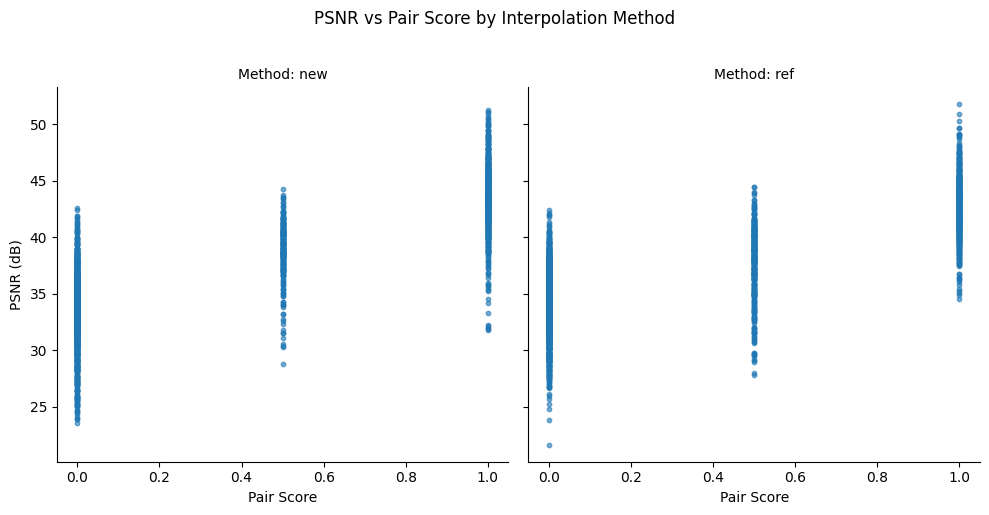

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a FacetGrid to plot PSNR vs Score for each method
g = sns.FacetGrid(scatter_df, col="method", height=5, aspect=1)
g.map(plt.scatter, "score", "psnr", alpha=0.6, s=10)

# Add titles and labels
g.set_axis_labels("Pair Score", "PSNR (dB)")
g.set_titles("Method: {col_name}")
plt.suptitle('PSNR vs Pair Score by Interpolation Method', y=1.02) # Add a main title
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

## Box Plots

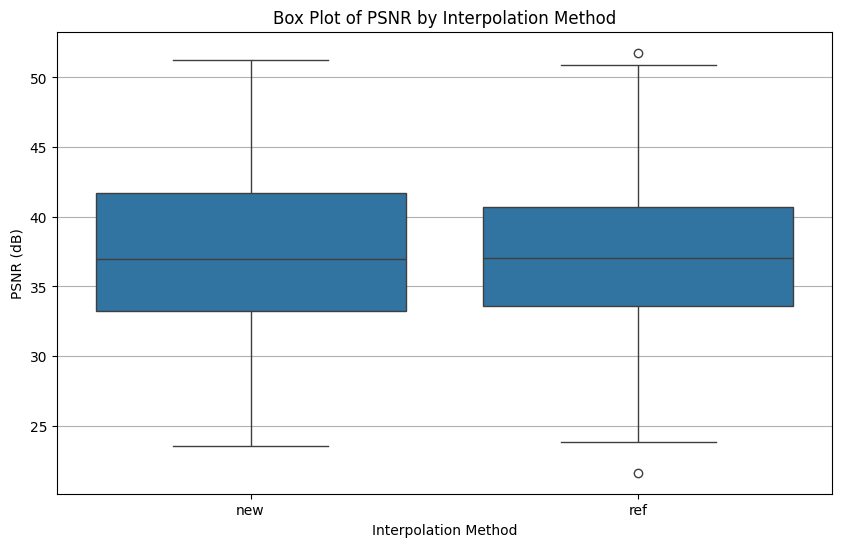

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=scatter_df, x='method', y='psnr')
plt.xlabel('Interpolation Method')
plt.ylabel('PSNR (dB)')
plt.title('Box Plot of PSNR by Interpolation Method')
plt.grid(axis='y')
plt.show()